# TP3: Essential Matrix

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. 

Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.

Return your work by e-mail at `gabriel.fiastre@inria.fr` using a single file (ipynb or zip) with the format `LASTNAME_FirstName_TP2.ipynb`


#### This assignment is about Two-view (Stereo) Geometry : you will compute the **Essential Matrix** F associated with N correspondences from the "house" data. You will estimate the matrix, compute the epipolar lines and implement Hartley's normalization to improve results.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

**0)** Define your path to the folder containing the data points:

In [4]:
path = 'C:/Users/murat/OneDrive - enpc.fr/3A/Vision artificielle/TP3/HouseData'

You can directly use the following functions, especially `read_data` to load points in two chosen views, and `plot_edges` to visualize points from one view and the edges connecting them.

In [5]:
def file_to_array(file_path):
    """
    Params:
    -------
    file_path: str
        path to file with image points.
    
    Returns:
    --------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    """
    with open(file_path) as f:
        views = dict()
        pt2d = f.readlines()
        for line in pt2d:
            if len(line.split(" ")) == 3:
                pt_id = line.split(" ")[0]
                views[pt_id] = (float(line.split(" ")[1]), float(line.split(" ")[2][:-1]))
    pts = np.zeros((len(views), 2))
    for i in range(len(pts)):
        pts[i] = views[str(i+1)] 

    return pts


def read_data(data_path, idx1, idx2):
    """
    Params:
    -------
    data_path: str
        path to folder where 'pt_2D{}' are stored.
    idx1: int
        idx of first view.
    idx2: int 
        idx of second view.
    
    
    Returns:
    --------
    pts1, pts2, edges_processed
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx2.
    edges_processed: list
        list of tuples. (i, j) is in edges_processed if there is an edge between 
        point of idx i and point of idx j.
    """
    pt1_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx1))
    pt2_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx2))
    
    pts1 = file_to_array(file_path=pt1_2D_path)
    pts2 = file_to_array(file_path=pt2_2D_path)
    
    # Load edges
    edges_path = os.path.join(path, 'edges')

    with open(edges_path) as f:
        edges_raw = f.readlines()
        
    edges_processed = []
    for edge in edges_raw:
        if len(edge.split(" ")) == 2:
            edges_processed.append((int(edge.split(" ")[0]), int(edge.split(" ")[1][:-1])))
    min_points = np.minimum(len(pts1), len(pts2))
    
    return pts1[:min_points], pts2[:min_points], edges_processed


def plot_edges(pts, edges):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    edges: list
        list of tuples. (i, j) is in edges if there is an edge between points of indices i and j.
    
    Plots edges.
    """
    
    plt.figure()
    for i, edge in enumerate(edges):
        #print(i)
        coord1 = pts[edges[i][0] - 1]
        coord2 = pts[edges[i][1] - 1]
        x = [coord1[0], coord2[0]]
        y = [coord1[1], coord2[1]]
        plt.plot(x, y, 'ro-')

For this exercise, let us use views 2 and 5 of the house:

**1)** Load the data corresponding to images 2 and 5 using `read_data`.

In [6]:
######################
# Complete that part #
######################
image_2, image_5, edges = read_data(path,2,5)

**2)** Use `plot_edges` to show show the edges overlayed over images 2 and 5.

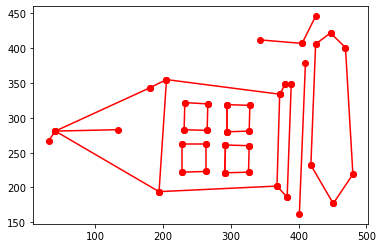

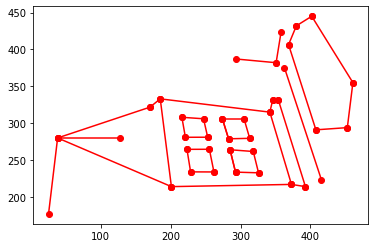

In [7]:
######################
# Complete that part #
######################
plot_edges(image_2,edges)
plot_edges(image_5,edges)

**3.a)** Compute the fundamental matrix F directly from these points using
homogeneous linear least-squares.

In [50]:
# Compute the fundamental matrix F using homogeneous linear least-squares
def compute_F(pts1, pts2):
   """
   Params:
   -------
   pts1: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 1.
   pts2: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 2.
   
   Returns:
   --------
   F: np.array
         array of size (3, 3). Fundamental matrix.
   """

   #Building the matrix P made up by the points
   n=pts1.shape[0]
   homogenous_pts1=np.c_[pts1,np.ones(n)]
   homogenous_pts2=np.c_[pts2,np.ones(n)]
   P = (homogenous_pts1[:,:,None]*homogenous_pts2[:,None,:]).reshape(n,-1)

   # Compute SVD of P
   U, S, V = np.linalg.svd(P)

   # Solve for F
   sol = V[-1,:]
   F = sol.reshape((3,3))
   return F


n=image_2.shape[0]
homogenous_pts1=np.c_[image_2,np.ones(n)]
homogenous_pts2=np.c_[image_5,np.ones(n)]
F = compute_F(image_2,image_5)

# Check that F solves the equation
print("Norm of F:",np.sum(F**2))
print(np.diag(homogenous_pts1 @ F @ homogenous_pts2.T),"We see xfF' is close to zero for all corresponding points")


    

Norm of F: 1.0
[ 0.01551555  0.04617415 -0.0390034  -0.05893176  0.04715965  0.05979841
  0.02338496 -0.00959744 -0.02088147 -0.01907064  0.028957   -0.03159791
 -0.0392957   0.00095371 -0.00506877 -0.02899515  0.11410553 -0.0048906
  0.06059002  0.05610982  0.02159157 -0.05628412 -0.01659678  0.05125203
 -0.0341581  -0.03537054 -0.04162839  0.00641012  0.00208082 -0.00843377
  0.02828823  0.02708631 -0.03921741  0.03207219 -0.01754699 -0.06702213
  0.0238216  -0.01261366] We see xfF' is close to zero for all corresponding points


**3.b)** Report the mean distance between the points (for example from view 1) and the corresponding epipolar lines.

In [9]:
def compute_mean_distance(pts1, pts2, F):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    F: np.array
        array of size (3, 3). Fundamental matrix.

    Returns:
    --------
    mean_distance: float
        mean distance between points (view 1) and epipolar lines (view 2)
    """

    distances = []

    for i in range(len(pts1)):
        # Get homogeneous coordinates
        homogenous_pts1=np.append(pts1[i],1)
        homogenous_pts2=np.append(pts2[i],1)
        line = F @ homogenous_pts2
        distance = np.abs(line.T @ homogenous_pts1) / np.linalg.norm(line[:2])
        distances.append(distance)
        
    return np.mean(distances)



In [10]:
# Check distances
F = compute_F(image_2,image_5)
initial_error = compute_mean_distance(image_2,image_5, F)
print(initial_error)


14.767366980624445


**4.a)** Write a function, that given F, draws the epipolar lines associated
with the points from pts1, and overlays them on the points from
pts2, drawn using plot_edges.

In [51]:
def draw_epipolar_lines(pts1, pts2, F, edges):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    F: np.array
        array of size (3, 3). Fundamental matrix.

    Returns:
    --------
    lines: list
        list of tuples. Each tuple contains the coordinates of the two extremal points of the epipolar segment drawn.
    """
    lines = []

    plot_edges(pts2, edges)

    for i in range(len(pts1)):
        homogenous_pts1=np.append(pts1[i],1)
        homogenous_pts2=np.append(pts2[i],1)
        line = homogenous_pts1 @ F 
        line_perp = np.append(line[:2],0)
        
        #calculating projection
        p_hat = homogenous_pts2 - ((line.T @ homogenous_pts2) / np.linalg.norm(line[:2])**2) * line_perp

        #getting epipolar segment's extremities
        line_vector = np.array([1,-line[0]/line[1]])
        line_vector /= np.linalg.norm(line_vector)
        start_seg = p_hat[:2] - 25*line_vector
        end_seg = p_hat[:2] + 25*line_vector
        lines.append((start_seg,end_seg))

        #plot projection
        plt.plot([p_hat[0],pts2[i][0]],[p_hat[1],pts2[i][1]],c='red',linewidth=1,linestyle='dashed')

        #plot epipolar segment
        plt.plot([start_seg[0],end_seg[0]],[start_seg[1],end_seg[1]],c='blue')


    return lines

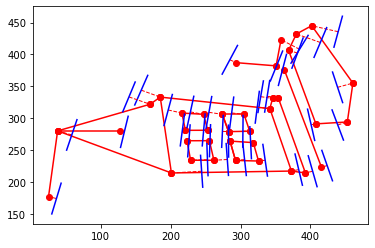

In [52]:
epi_lines = draw_epipolar_lines(image_2, image_5, F, edges)

**4.b)** Do the same switching the roles of pts1 and pts2.

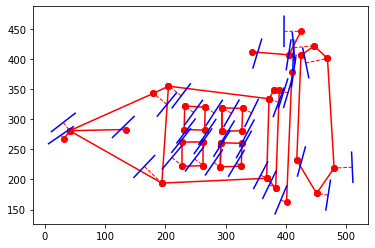

In [55]:
epi_lines = draw_epipolar_lines(image_5, image_2, F.T, edges)

**5)** Do the same thing using the Harltley normalization:

**5.a)** Compute the matrices $T_1$ and $T_2$.

In [14]:
def compute_T(pts):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.

    Returns:
    --------
    T: matrix
        3x3 matrix. Projection matrix to normalize the data
    """
    mu_x = np.mean(pts[:,0])
    mu_y = np.mean(pts[:,1])
    sigma = np.mean(np.linalg.norm(pts-np.array([mu_x,mu_y])))

    T = np.array([[np.sqrt(2)/sigma,0,-np.sqrt(2)/sigma*mu_x],
                  [0,np.sqrt(2)/sigma,-np.sqrt(2)/sigma*mu_y],
                  [0,0,1]])
    
    return T

In [15]:
T1 = compute_T (image_2)
T2 = compute_T (image_5)
homogenous_pts1=np.c_[image_2,np.ones(n)]
homogenous_pts2=np.c_[image_5,np.ones(n)]

pts1_norm = (T1 @ homogenous_pts1.T).T
pts2_norm = (T2 @ homogenous_pts2.T).T

**5.b)** Compute the new matrice $F'$

In [16]:
F_tilde = compute_F(pts1_norm[:,:2], pts2_norm[:,:2])

#Compute again SVD
U, S, V = np.linalg.svd(F_tilde)

#Forcing rank 2
S[-1] = 0

#Reassembling the matrix
F_star = U @ np.diag(S) @ V

#Bringing back to the original coordinates
F_opt = T1.T @ F_star @ T2

**5.c)** Report the mean distance between the points and the corresponding epipolar lines.

In [17]:
new_error = compute_mean_distance(image_2,image_5, F_opt)
percentage_dif = (new_error-initial_error)/initial_error*100
print(f'The error after normalization is {new_error:.4f} that is {percentage_dif:.2f}% lower than the original estimate')

The error after normalization is 0.9730 that is -93.41% lower than the original estimate


**5.d)** Draw the epipolar lines associated with the points from `pts2` and overlay them on the points from
`pts1`, drawn using `plot_edges`.

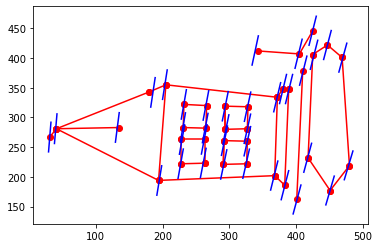

In [59]:
epi_lines = draw_epipolar_lines(image_5,image_2, F_opt.T, edges)

**5.e)** Do the same switching the roles of `pts1` and `pts2`.

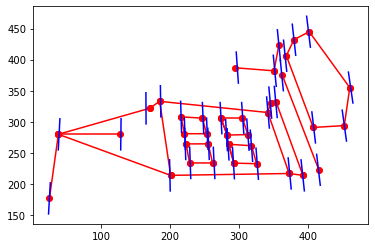

In [57]:
epi_lines = draw_epipolar_lines(image_2,image_5, F_opt, edges)

Graphically we can conclude the epipolar lines became much closer to their corresponding points, which had been indicated by the reduction of the mean distance computed earlier